In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import seaborn as sb
from scipy import stats
import sys
import os
sys.path.append('/storage/brno14-ceitec/shared/softmatter/shakespearem/BLOCKING')
from main import BlockAnalysis
from MDAnalysis import transformations
import pandas as pd
from scipy.optimize import least_squares
import glob
from scipy.spatial import ConvexHull
from lxml import etree
from tqdm import tqdm
from localcider.sequenceParameters import SequenceParameters
from MDAnalysis.lib.distances import distance_array

#Acknowledgement - Thank you to Guilio Tesei for making your code and data so readily available.

mass_scale = .7
mass = {
    'MET': 131.199997, 'GLY': 57.049999, 'LYS': 128.199997, 'THR': 101.099998, 'ARG': 156.199997, 'ALA': 71.080002,
    'ASP': 115.099998, 'GLU': 129.100006, 'TYR': 163.199997, 'VAL': 99.07, 'LEU': 113.199997, 'GLN': 128.100006,
    'TRP': 186.199997, 'PHE': 147.199997, 'SER': 87.080002, 'HIS': 137.100006, 'ASN': 114.099998, 'PRO': 97.120003,
    'CYS': 103.099998, 'ILE': 113.199997, 'SEP': 165.03,
    # Scaled masses
    'MET2': 131.199997 * mass_scale, 'GLY2': 57.049999 * mass_scale, 'LYS2': 128.199997 * mass_scale,
    'THR2': 101.099998 * mass_scale, 'ARG2': 156.199997 * mass_scale, 'ALA2': 71.080002 * mass_scale,
    'ASP2': 115.099998 * mass_scale, 'GLU2': 129.100006 * mass_scale, 'TYR2': 163.199997 * mass_scale,
    'VAL2': 99.07 * mass_scale, 'LEU2': 113.199997 * mass_scale, 'GLN2': 128.100006 * mass_scale,
    'TRP2': 186.199997 * mass_scale, 'PHE2': 147.199997 * mass_scale, 'SER2': 87.080002 * mass_scale,
    'HIS2': 137.100006 * mass_scale, 'ASN2': 114.099998 * mass_scale, 'PRO2': 97.120003 * mass_scale,
    'CYS2': 103.099998 * mass_scale, 'ILE2': 113.199997 * mass_scale, 'SEP2': 165.03 * mass_scale,
}

def plotRgDist(ax,rgarray,c,label):
    edges = np.arange(rgarray.min(),rgarray.max(),.1)
    x = edges[:-1]+(edges[1]-edges[0])/2.
    h,_ = np.histogram(rgarray,bins=edges,density=True)
    sb.histplot(rgarray,color=c,label=label,ax=ax,y=None)
    return x,h

def plotCprofile(ax,h,c=1,label='Protein'):
    lz = (h.shape[1]+1)
    edges = np.arange(-lz/2.,lz/2.,1)/10
    dz = (edges[1]-edges[0])/2.
    z = edges[:-1]+dz
    profile = lambda x,a,b,c,d : .5*(a+b)+.5*(b-a)*np.tanh((np.abs(x)-c)/d)
    residuals = lambda params,*args : ( args[1] - profile(args[0], *params) )
    hm = np.mean(h,axis=0)
    z1 = z[z>0]
    h1 = hm[z>0]
    z2 = z[z<0]
    h2 = hm[z<0]
    p0=[hm.min(),hm.max(),3,1]
    res1 = least_squares(residuals, x0=p0, args=[z1, h1], bounds=([0]*4,[1e3]*4))
    res2 = least_squares(residuals, x0=p0, args=[z2, h2], bounds=([0]*4,[1e3]*4))
    ax.plot(z1,h1,color=cm[c],lw=2,label=label)
    ax.plot(z2,h2,color=cm[c],lw=2)
    ax.plot(z,profile(z,*res1.x),color=cm[c],lw=.5)
    ax.plot(z,profile(z,*res2.x),color=cm[c],lw=.5)
    ax.set_yscale('log')
    ax.set_xlabel('$z$  /  nm')
    ax.set_xlim(-lz/20,lz/20)
    ax.set_ylim(1e-2,1e2)
    if (res1.x[3]>res1.x[2]) or (res2.x[3]>res2.x[2]):
        zDS = res1.x[2] if res1.x[2]>res2.x[2] else res2.x[2]
        zDS = 10 if zDS<1 else zDS
        cutoffs1 = [zDS,-zDS]
        cutoffs2 = [zDS+25,-zDS-25]
    else:
        cutoffs1 = [res1.x[2]-.5*res1.x[3],-res2.x[2]+.5*res2.x[3]]
        cutoffs2 = [res1.x[2]+6*res1.x[3],-res2.x[2]-6*res2.x[3]]
    #ax.vlines(cutoffs2,1e-3,1e2,color=cm[0],ls=':')
    #ax.vlines(cutoffs1,1e-3,1e2,color='k',ls=':')


def calc_zpatch(z,h,cutoff=0):
    ct = 0.
    ct_max = 0.
    zwindow = []
    hwindow = []
    zpatch = [] 
    hpatch = []
    for ix, x in enumerate(h):
        if x > cutoff:
            ct += x
            zwindow.append(z[ix])
            hwindow.append(x)
        else:
            if ct > ct_max:
                ct_max = ct
                zpatch = zwindow
                hpatch = hwindow
            ct = 0.
            zwindow = []
            hwindow = []
    if ct > ct_max: # edge case (slab at side of box)
        zpatch = zwindow
        hpatch = hwindow
    zpatch = np.array(zpatch)
    hpatch = np.array(hpatch)
    return zpatch, hpatch

def d_plot(pdb_file,dcd_file,start,end,step,dim=None):
    u = mda.Universe(f'{pdb_file}',f'{dcd_file}',in_memory=True)
    if dim:
        workflow = [transformations.boxdimensions.set_dimensions(dim)]
        u.trajectory.add_transformations(*workflow)
        u.dimensions = dim
    n_frames = len(u.trajectory[start:end:step])
    ag = u.atoms # all atoms (also used for dcd output)
    ag_ref = u.select_atoms('all') # reference group for centering

    lz = u.dimensions[2]
    edges = np.arange(0,lz+1,1)
    dz = (edges[1] - edges[0]) / 2.
    z = edges[:-1] + dz
    n_bins = len(z)
    nframes = len(u.trajectory[start:end:step])
    hs = np.zeros((n_frames,n_bins))

    for t,ts in tqdm(enumerate(u.trajectory[start:end:step]),
    total=nframes, mininterval=1):
        zpos = ag_ref.positions.T[2]
        h, e = np.histogram(zpos,bins=edges)
        zmax = z[np.argmax(h)]
        ag.translate(np.array([0,0,-zmax+0.5*lz]))
        ts = transformations.wrap(ag)(ts) # wrap
        zpos = ag_ref.positions.T[2]
        h, e = np.histogram(zpos, bins=edges)
        zpatch, hpatch = calc_zpatch(z,h)
        zmid = np.average(zpatch,weights=hpatch) # center of mass of slab
        ag.translate(np.array([0,0,-zmid+0.5*lz]))
        ts = transformations.wrap(ag)(ts) # wrap
        zpos = ag.positions.T[2]
        h, e = np.histogram(zpos,bins=edges)
        hs[t] = h

    h = hs
    N = len(u.segments[0].atoms)
    L = u.dimensions[0]/10
    conv = 100/6.022/N/L/L*1e3
    h = h*conv # corresponds to (binned) concentration in mM
    lz = h.shape[1]+1
    edges = np.arange(-lz/2.,lz/2.,1)/10
    dz = (edges[1]-edges[0])/2.
    z = edges[:-1]+dz
    profile = lambda x,a,b,c,d : .5*(a+b)+.5*(b-a)*np.tanh((np.abs(x)-c)/d) # hyperbolic function, parameters correspond to csat etc.
    residuals = lambda params,*args : ( args[1] - profile(args[0], *params) )
    hm = np.mean(h,axis=0)
    z1 = z[z>0]
    h1 = hm[z>0]
    z2 = z[z<0]
    h2 = hm[z<0]
    p0=[1,1,1,1]
    res1 = least_squares(residuals, x0=p0, args=[z1, h1], bounds=([0]*4,[100]*4)) # fit to hyperbolic function
    res2 = least_squares(residuals, x0=p0, args=[z2, h2], bounds=([0]*4,[100]*4))
    cutoffs1 = [res1.x[2]-res1.x[3],-res2.x[2]+res2.x[3]] # position of interface - half width
    cutoffs2 = [res1.x[2]+res1.x[3],-res2.x[2]-res2.x[3]] # get far enough from interface for dilute phase calculation
    bool1 = np.logical_and(z<cutoffs1[0],z>cutoffs1[1]) # dense
    bool2 = np.logical_or(z>cutoffs2[0],z<cutoffs2[1]) # dilute

    if (np.abs(cutoffs2[1]/cutoffs2[0]) > 2) or (np.abs(cutoffs2[1]/cutoffs2[0]) < 0.5): # ratio between right and left should be close to 1
            print('NOT CONVERGED',cutoffs1,cutoffs2)
            print(res1.x,res2.x)

    cdil = hm[bool2].mean() # average concentration # CHANGED
    cden = hm[bool1].mean() # CHANGED
    dilarray = np.apply_along_axis(lambda a: a[bool2].mean(), 1, h) # concentration in range [bool2]
    denarray = np.apply_along_axis(lambda a: a[bool1].mean(), 1, h)
    try:
        block_dil = BlockAnalysis(dilarray)
        block_den = BlockAnalysis(denarray)
        block_dil.SEM()
        block_den.SEM()
        print(cden,block_den.sem)
    except:
        print(cden)
    pos = np.mean([profile(z1, *res1.x),profile(z1, *res2.x)],axis=0)
    neg = np.mean([profile(z2, *res1.x),profile(z2, *res2.x)],axis=0)
    return h,pos,neg,cdil,cden,z1,z2

def load(fname):
    tree = etree.parse(fname)
    root = tree.getroot()
    data = []

    for marker in root.iter('marker'):
        id_ = int(marker.attrib['id'])
        x = float(marker.attrib['x'])
        y = float(marker.attrib['y'])
        z = float(marker.attrib['z'])
        coordX = float(marker.attrib['coordX'].rstrip('px'))
        coordY = float(marker.attrib['coordY'].rstrip('px'))
        coordZ = float(marker.attrib['coordZ'].rstrip('px'))
        data.append([id_, x, y, z, coordX, coordY, coordZ])

    df = pd.DataFrame(data, columns=['id', 'x', 'y', 'z', 'coordX', 'coordY', 'coordZ'])
    df = center(df)
    return df[['x', 'y', 'z']].values

def center(df):
    mean_x = df['x'].mean()
    mean_y = df['y'].mean()
    mean_z = df['z'].mean()
    df_centered = df.copy()
    df_centered['x'] = df['x'] - mean_x
    df_centered['y'] = df['y'] - mean_y
    df_centered['z'] = df['z'] - mean_z
    return df_centered

def all_points_above_or_on_line(p1, p2, points):
    slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
    intercept = p1[1] - slope * p1[0]
    
    for point in points:
        line_y_at_point_x = slope * point[0] + intercept
        if point[1] < line_y_at_point_x:
            return False
    return True

def contact_map(u,cutoff_distance,chain_len_1,chain_len_2,start,stop,step):
    # Process the last 'num_timesteps' frames
    contacts = np.zeros((chain_len_1, chain_len_2))
    for ts in tqdm(u.trajectory[start:stop:step]):
        for i, chain1 in enumerate(u.segments):
            if len(chain1.atoms) == chain_len_1:
                for j, chain2 in enumerate(u.segments):
                    if len(chain2.atoms) == chain_len_2:
                        if i < j:  # Avoid double counting and self-interaction
                            # Get the positions of all atoms in each chain
                            pos_chain1 = chain1.atoms.positions
                            pos_chain2 = chain2.atoms.positions

                            # Calculate the distance matrix between the two sets of positions
                            distances = distance_array(pos_chain1, pos_chain2)
                            mask = distances < cutoff_distance
                            # Increment the contact matrix if any distance is below the cutoff
                            contacts += mask

    average_contacts = (contacts - np.min(contacts))/(np.max(contacts)-np.min(contacts))
    return average_contacts

/home/shakespearem/.conda/envs/omm2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shakespearem/.conda/envs/omm2/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


<>:40: SyntaxWarning: invalid escape sequence '\A'
<>:44: SyntaxWarning: invalid escape sequence '\A'
<>:40: SyntaxWarning: invalid escape sequence '\A'
<>:44: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_897375/2740511256.py:40: SyntaxWarning: invalid escape sequence '\A'
  plotRgDist(axes[idx], rg_array, c[idx], f'{labels[idx]}\n$R_g$ = {int(np.mean(rg_array))} $\AA$')
/tmp/ipykernel_897375/2740511256.py:44: SyntaxWarning: invalid escape sequence '\A'
  axes[idx].set_xlabel('$R_g$ ($\AA$)', fontsize=12)
/home/shakespearem/.conda/envs/omm2/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:346: UserWarning: Unknown element EP found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn(wmsg)
/home/shakespearem/.conda/envs/omm2/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently m

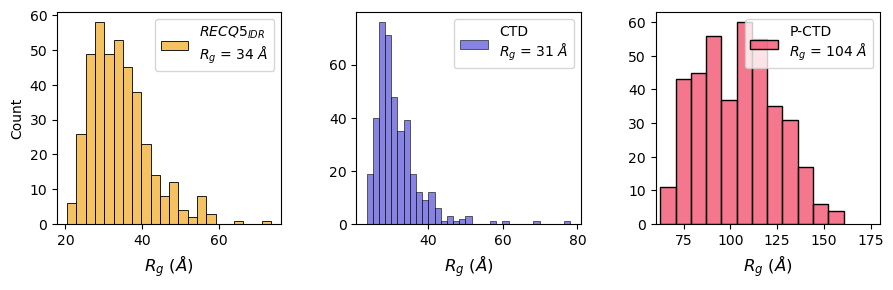

In [ ]:
#EXTENDED FIGURE 7A - RADIUS OF GYRATION FOR IDRs
# Define colors for the plots
c = ['#F2AE2E', '#5D59D9', '#F24968']

# Define system directories and labels for different conditions
direc = ['rg_idr', 'rg_ctd', 'rg_pctd']
labels = ['$RECQ5_{IDR}$', 'CTD', 'P-CTD']

# Create figure and subplots
fig = plt.figure(figsize=(9,3))
ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan=1)
axes = [ax1, ax2, ax3]

# Create directory for raw data if it doesn't exist
os.makedirs('raw', exist_ok=True)

# Loop through each system and compute the radius of gyration
for idx, dir in enumerate(direc):
    u = mda.Universe(f'../Radius_Of_Gyration/{dir}.pdb', f'../Radius_Of_Gyration/{dir}.dcd')
    u.atoms.masses = [mass[i] for i in u.atoms.names]
    rg = [] 

    # Iterate through frames, skipping the first microsecond and measuring every nanosecond
    for ts in u.trajectory[1000:5000:10]:
        rg.append(u.atoms.radius_of_gyration())
        
    rg_array = np.asarray(rg)
    raw_data_filename = f'raw/{dir}_Rg.csv'
    pd.DataFrame({'Frame': np.arange(len(rg_array)), 'Rg': rg_array}).to_csv(raw_data_filename, index=False)
    plotRgDist(axes[idx], rg_array, c[idx], f'{labels[idx]}\n$R_g$ = {int(np.mean(rg_array))} $\AA$')
    axes[idx].legend()
    axes[idx].set_xlabel('$R_g$ ($\AA$)', fontsize=12)

# Adjust axis properties
ax3.set_xlim([60, 180])
ax2.set_ylabel('')
ax3.set_ylabel('')

# Adjust layout and save figure
fig.tight_layout(w_pad=3)
fig.savefig('figures/Rg.pdf', dpi=300, format='pdf')

/home/shakespearem/.conda/envs/omm2/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:346: UserWarning: Unknown element EP found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn(wmsg)
/home/shakespearem/.conda/envs/omm2/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
100%|██████████| 299/299 [00:02<00:00, 125.90it/s]


17.12344688222035 0.04302737666404777


100%|██████████| 129/129 [00:01<00:00, 76.45it/s]


37.18983053918791 0.2994108251436486


100%|██████████| 52/52 [00:00<00:00, 60.98it/s]


41.972826142044006 0.3010217633948469


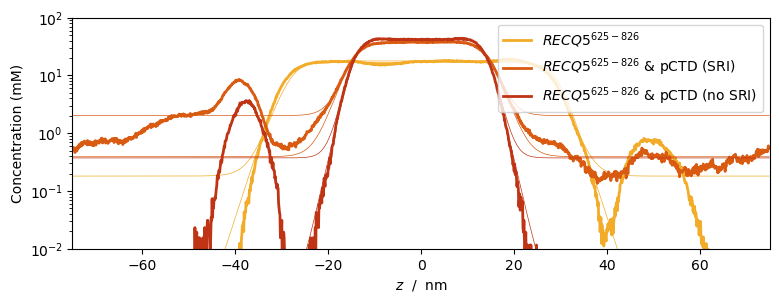

In [ ]:
#UNUSED FIGURE - Looking at how the SRI-CTD interactions can create more stable condensates
# Define colors for the plots
cm = ['#F2AC29', '#D95A11', '#BF3415']

# Define labels for the different conditions
labels = ['$RECQ5^{625-826}$', 'CTD', 'p5CTD']

# Define simulation box dimensions (X, Y, Z)
dim = [150, 150, 1500, 90, 90, 90]

# Create figure and axis
f, ax = plt.subplots(1, 1, figsize=(9,3))

# Create directory for raw data if it doesn't exist
os.makedirs('raw', exist_ok=True)

# ---- Simulation 1: RECQ5^{625-826} ---- #
pdb_file = '../IDR_Slab/HPSUrry/296/test_simulation.pdb'
dcd_file = '../IDR_Slab/HPSUrry/296/test_simulation.dcd'


h_d, pos_d, neg_d, cdil, cden_d, z1_d, z2_d = d_plot(pdb_file, dcd_file, -300, -1, 1, dim)
z_d = np.concatenate((z2_d, z1_d))
pd.DataFrame({'Z': z_d, 'Concentration': np.mean(h_d,axis=0)}).to_csv('raw/idr_slab_RECQ5_625_826.csv', index=False)
plotCprofile(ax, h_d, 0, '$RECQ5^{625-826}$')

# ---- Simulation 2: RECQ5^{625-826} & pCTD (SRI) ---- #
pdb_file = '../IDR_CTD/idr_ctd_nosri.pdb'
dcd_file = '../IDR_CTD/idr_ctd_nosri.dcd'

# Extract data
h_d, pos_d, neg_d, cdil, cden_d, z1_d, z2_d = d_plot(pdb_file, dcd_file, 0, -1, 1, dim)
z_d = np.concatenate((z2_d, z1_d))
pd.DataFrame({'Z': z_d, 'Concentration': np.mean(h_d,axis=0)}).to_csv('raw/idr_slab_RECQ5_625_826_pCTD_SRI.csv', index=False)
plotCprofile(ax, h_d, 1, '$RECQ5^{625-826}$ & pCTD (SRI)')

# ---- Simulation 3: RECQ5^{625-826} & pCTD (No SRI) ---- #
pdb_file = '../IDR_CTD/idr_ctd_sri.pdb'
dcd_file = '../IDR_CTD/idr_ctd_sri.dcd'

# Extract data
h_d, pos_d, neg_d, cdil, cden_d, z1_d, z2_d = d_plot(pdb_file, dcd_file, 0, -1, 1, dim)
z_d = np.concatenate((z2_d, z1_d))
pd.DataFrame({'Z': z_d, 'Concentration': np.mean(h_d,axis=0)}).to_csv('raw/idr_slab_RECQ5_625_826_pCTD_noSRI.csv', index=False)
plotCprofile(ax, h_d, 2, '$RECQ5^{625-826}$ & pCTD (no SRI)')

# Set axis labels and legend
ax.set_ylabel('Concentration (mM)')
ax.legend(loc='upper right')

# Adjust layout and save figure
fig.tight_layout(w_pad=3)
fig.savefig('figures/idr_slab_with_pctd.pdf', dpi=300, format='pdf')


/home/shakespearem/.conda/envs/omm2/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:346: UserWarning: Unknown element EP found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn(wmsg)
/home/shakespearem/.conda/envs/omm2/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
100%|██████████| 299/299 [00:02<00:00, 128.41it/s]


17.12344688222035 0.04302737666404777


100%|██████████| 299/299 [00:02<00:00, 101.87it/s]


17.61902105714078 0.02633923986309874


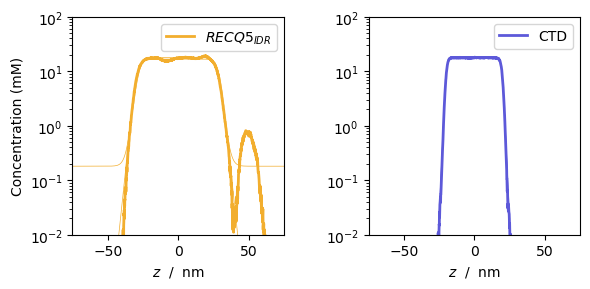

In [ ]:
#EXTENDED FIGURE 7B - CONCENTRATION OF DENSE/DILUTE PHASE OF IDRs.
#P-CTD ONLY HAD A DILUTE PHASE, SO THIS GRAPH IS IGNORED

# Define colors for the plots
cm = ['#F2AE2E', '#5D59D9', '#F24968']

# Define labels for the different conditions
labels = ['$RECQ5_{IDR}$', 'CTD']

# Create figure and subplots
fig = plt.figure(figsize=(6,3))
ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan=1)

# Define simulation box dimensions (X, Y, Z)
dim = [150, 150, 1500, 90, 90, 90]

# Create directory for raw data if it doesn't exist
os.makedirs('raw', exist_ok=True)

# ---- Simulation 1: RECQ5_{IDR} ---- #
pdb_file = '../IDR_Slab/HPSUrry/296/test_simulation.pdb'
dcd_file = '../IDR_Slab/HPSUrry/296/test_simulation.dcd'

h_d, pos_d, neg_d, cdil, cden_d, z1_d, z2_d = d_plot(pdb_file, dcd_file, -300, -1, 1, dim)
z_d = np.concatenate((z2_d, z1_d))
h_mean = np.mean(h_d, axis=0)
pd.DataFrame({'Z': z_d, 'Mean Concentration': h_mean}).to_csv('raw/phase_sep_RECQ5_IDR.csv', index=False)
plotCprofile(ax1, h_d, 0, labels[0])

# ---- Simulation 2: CTD ---- #
pdb_file = '../../CTD/perfect_52/HPSUrry/296/test_simulation.pdb'
dcd_file = '../../CTD/perfect_52/HPSUrry/296/test_simulation.dcd'


h_d, pos_d, neg_d, cdil, cden_d, z1_d, z2_d = d_plot(pdb_file, dcd_file, -300, -1, 1, dim)
z_d = np.concatenate((z2_d, z1_d))
h_mean = np.mean(h_d, axis=0)
pd.DataFrame({'Z': z_d, 'Mean Concentration': h_mean}).to_csv('raw/phase_sep_CTD.csv', index=False)
plotCprofile(ax2, h_d, 1, labels[1])

# Set legend and labels
ax1.legend()
ax2.legend()
ax1.set_ylabel('Concentration (mM)')

# Adjust layout and save figure
fig.tight_layout(w_pad=3)
fig.savefig('figures/phase_sep.pdf', dpi=300, format='pdf')


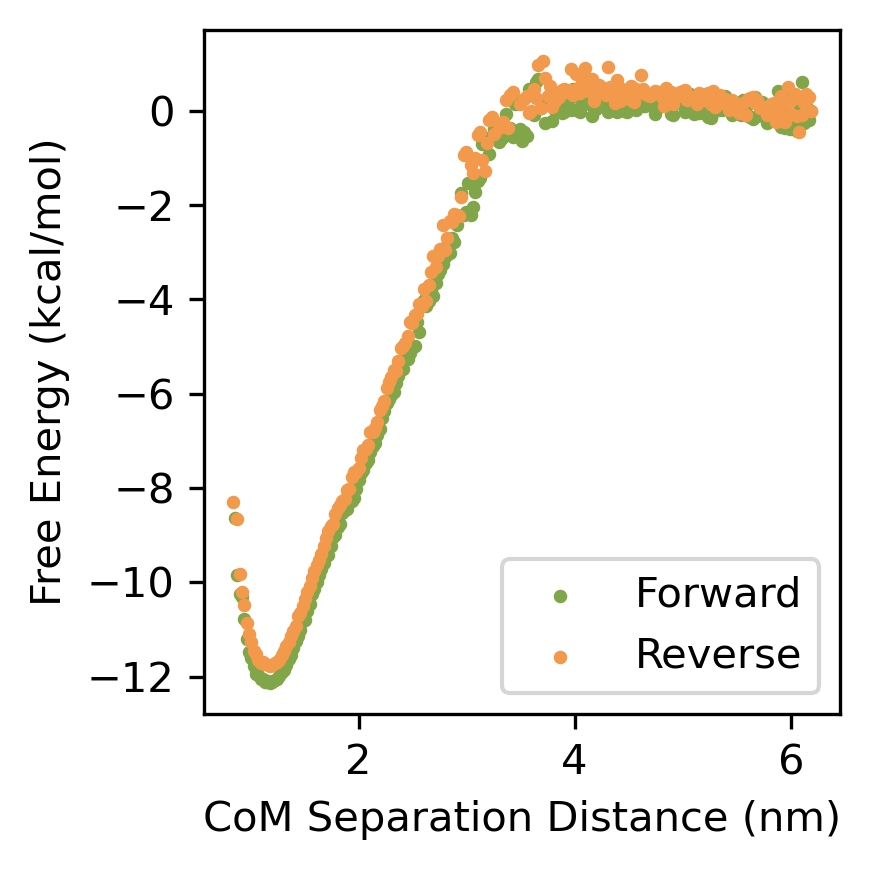

In [ ]:
#EXTENDED FIGURE 7E - A CHARGE OF 2.75 IS ADDED TO SRI BEADS - GIVING KD~ 10uMol BETWEEN SRI AND P-CTD
# Define file paths for input data
file_paths = ['../SRI_CTD_Contained/p25_2.75_0.0_1.0.txt', '../SRI_CTD_Contained/p25_2.75_1.0_1.0.txt']
labels = ['Forward', 'Reverse']
c = ['#81A649', '#F2994B']

# Initialize plot
plt.figure(dpi=300, figsize=(3,3))

# Create directory for raw data if it doesn't exist
os.makedirs('raw', exist_ok=True)

# Variable to track label index
use = 0
for file_path in file_paths:
    with open(file_path, 'r') as file:
        lines = file.readlines()

    coor, free_energy, free_energy_error = [], [], []
    for line in lines[1:]:  
        if line.startswith("#"):  # Skip commented lines
            continue
        entries = line.split()
        coor.append(float(entries[0]))
        free_energy.append(float('inf') if entries[1] == 'inf' else float(entries[1]))
        free_energy_error.append(float('nan') if entries[2] == 'nan' else float(entries[2]))

    coor = np.array(coor)
    free_energy = np.array(free_energy)
    free_energy[free_energy == np.inf] = np.nan
    valid_indices = ~np.isnan(free_energy) & ~np.isinf(free_energy)
    filtered_coor = coor[valid_indices]
    filtered_free_energy = free_energy[valid_indices]

    # Plot the free energy profile
    plt.scatter(filtered_coor, filtered_free_energy - filtered_free_energy[-1], label=labels[use], s=5, c=c[use])
    raw_filename = f'raw/p25_275_{labels[use].lower()}_free_energy.txt'
    np.savetxt(raw_filename, np.column_stack((filtered_coor, filtered_free_energy)), header="CoM_Separation_Distance(nm) Free_Energy(kcal/mol)", comments='')

    # Move to next label
    use += 1

# Set axis labels
plt.xlabel('CoM Separation Distance (nm)')
plt.ylabel('Free Energy (kcal/mol)')

# Add legend
plt.legend()

# Adjust layout and save figure
plt.tight_layout(w_pad=3)
plt.savefig('figures/sri_free_e_hist.pdf', format='pdf')


<>:72: SyntaxWarning: invalid escape sequence '\A'
<>:80: SyntaxWarning: invalid escape sequence '\A'
<>:86: SyntaxWarning: invalid escape sequence '\A'
<>:72: SyntaxWarning: invalid escape sequence '\A'
<>:80: SyntaxWarning: invalid escape sequence '\A'
<>:86: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_897375/392608924.py:72: SyntaxWarning: invalid escape sequence '\A'
  print(f"When num = {num_200}, the expected exp = {exp_200*1e-8:.4f} $x10^8 \AA^3$")
/tmp/ipykernel_897375/392608924.py:80: SyntaxWarning: invalid escape sequence '\A'
  ax.plot([x_min, x_max], [y_min, y_max], linestyle='--', color='k', label=f'{best_slope*1e-6:.2f}$x10^6 \AA^3$ / #')
/tmp/ipykernel_897375/392608924.py:86: SyntaxWarning: invalid escape sequence '\A'
  ax.set_ylabel('Volume of Condensate ($\AA^3$)')


../Experiments/Ytomo86.cmm
Files corresponding to the lowest slope line:
File 1: ../Experiments/Ytomo51.cmm
File 2: ../Experiments/Ytomo98.cmm
When num = 10, the expected exp = 0.2489 $x10^8 \AA^3$
When num = 20, the expected exp = 1.0861 $x10^8 \AA^3$


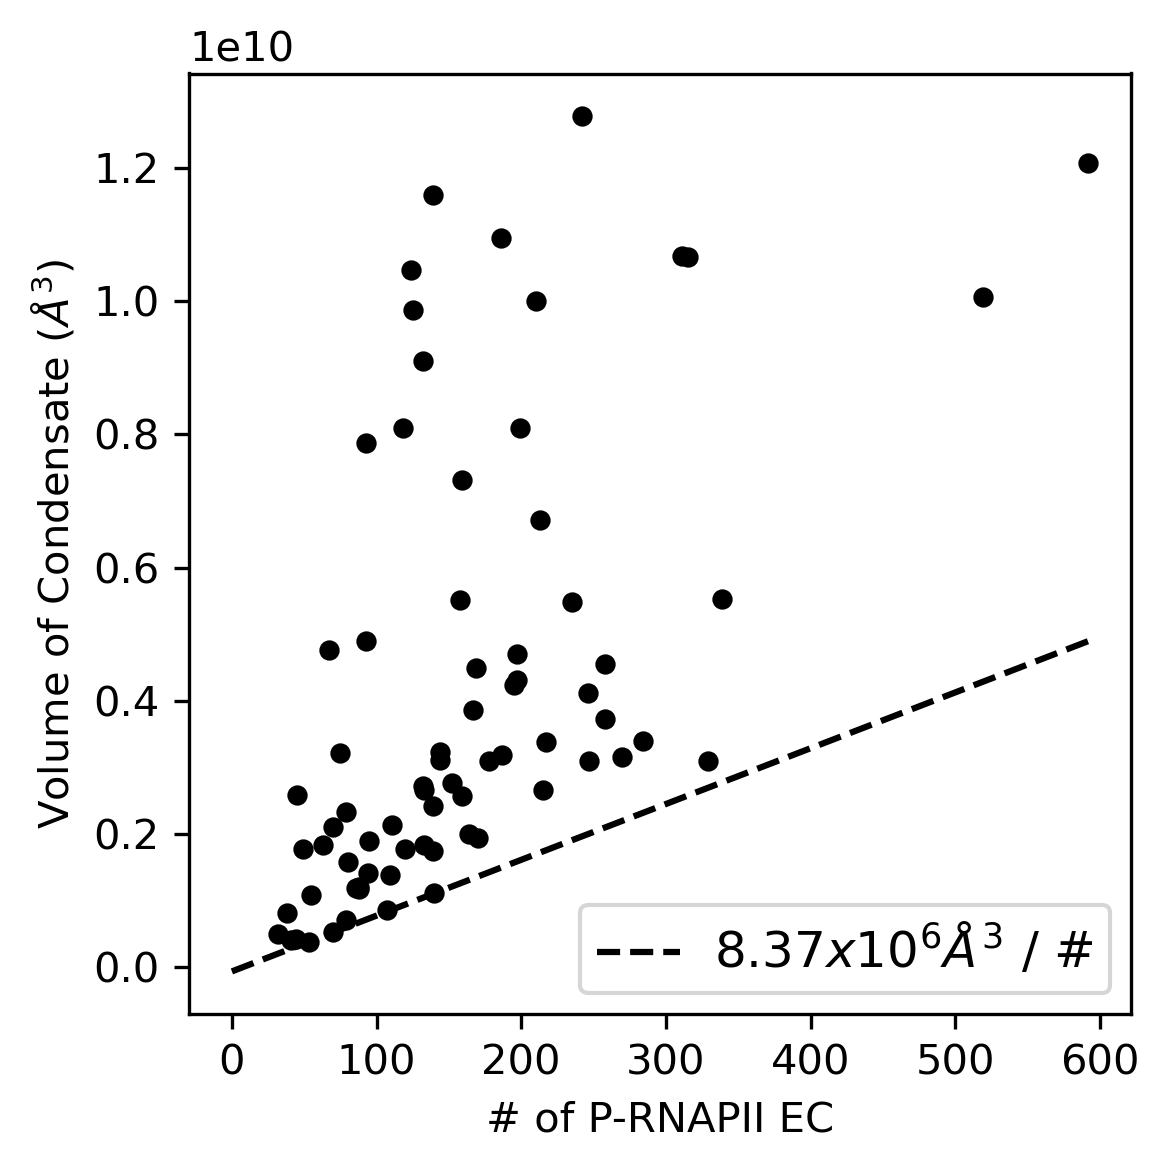

In [9]:
#UNUSED FIGURE - CONVEX HULL OF EXPERIMENTALLY RESOLVED CONDENSATES
# Load experimental data files
files = glob.glob('../Experiments/*.cmm')

# Initialize lists to store experimental data
exp = []  # List for condensate volumes
num = []  # List for number of points (P-RNAPII EC)
data_dict = {}  # Dictionary to store file names mapped to (num, exp) values

# Create directory for raw data if it doesn't exist
os.makedirs('raw', exist_ok=True)

# Process each file
for file in files:
    points = load(file)  # Load data points from file
    hull = ConvexHull(points)  # Compute convex hull
    radius = hull.volume  # Use volume of the convex hull as a measure
    num_points = len(points)  # Number of points in the file
    exp.append(radius)
    num.append(num_points)
    data_dict[(num_points, radius)] = file

# Save raw data
raw_data_filename = 'raw/experiment_condensate_volumes.csv'
pd.DataFrame({'# of P-RNAPII EC': num, 'Volume of Condensate (Å^3)': exp}).to_csv(raw_data_filename, index=False)

# Print the file corresponding to the largest condensate volume
print(data_dict[num[np.argmax(exp)], exp[np.argmax(exp)]])

# Convert points to numpy array and sort them by num (x-values)
points = np.array(list(zip(num, exp)))
sorted_points = points[np.argsort(points[:, 0])]
best_slope = float('inf')
best_points = None

# Find the pair of points with the lowest positive slope and no points below the line
for i in range(len(sorted_points) - 1):
    for j in range(i + 1, len(sorted_points)):
        p1, p2 = sorted_points[i], sorted_points[j]
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]

        if dx != 0 and dy > 0:
            slope = dy / dx
            if all_points_above_or_on_line(p1, p2, sorted_points):
                if slope < best_slope:
                    best_slope = slope
                    best_points = (p1, p2)

# Retrieve filenames of best points and calculate expected values
if best_points:
    p1, p2 = best_points
    file1 = data_dict[tuple(p1)]
    file2 = data_dict[tuple(p2)]

    print(f"Files corresponding to the lowest slope line:")
    print(f"File 1: {file1}")
    print(f"File 2: {file2}")

    # Calculate slope and intercept
    best_slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
    intercept = p1[1] - best_slope * p1[0]

    # Extend the line across the full range of x-values
    x_min, x_max = 0, max(num)
    y_min = best_slope * x_min + intercept
    y_max = best_slope * x_max + intercept

    # Calculate expected volume for num = 10 and num = 20
    for num_200 in [10, 20]:
        exp_200 = best_slope * num_200 + intercept
        print(f"When num = {num_200}, the expected exp = {exp_200*1e-8:.4f} $x10^8 \AA^3$")
    
else:
    print("No suitable line found")

# Create scatter plot
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=300)
ax.scatter(num, exp, c='k', s=15)
ax.plot([x_min, x_max], [y_min, y_max], linestyle='--', color='k', label=f'{best_slope*1e-6:.2f}$x10^6 \AA^3$ / #')

# Set labels and legend
ax.legend()
plt.xlabel('# of P-RNAPII EC')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='12')
ax.set_ylabel('Volume of Condensate ($\AA^3$)')

# Adjust layout and save figure
plt.tight_layout(w_pad=3)
plt.savefig('figures/Exp_Con_Vol.pdf', dpi=300, format='pdf')
plt.show()


In [ ]:
# TOOL TO GENERATE A PDB OF THE LAST FRAME. THIS IS USED FOR EXTENDED FIGURE 7C/D
# Input and output files
pdb_file = '../IDR_CTD/idr_ctd_nosri.pdb'
dcd_file = '../IDR_CTD/idr_ctd_nosri.dcd'
out_pdb_file = 'raw/idr_ctd_nosri.pdb'

# Define box dimensions (x, y, z, tilt_x, tilt_y, tilt_z)
dim = []
u = mda.Universe(pdb_file, dcd_file, in_memory=True)
ts = u.trajectory[-1]
u.trajectory[-1]

# Apply box dimensions if defined
if len(dim) == 6:
    workflow = [transformations.boxdimensions.set_dimensions(dim)]
    u.trajectory.add_transformations(*workflow)
    u.dimensions = dim

ag = u.atoms  # all atoms
ag_ref = u.select_atoms('all')  # reference group for centering
box_center = u.dimensions[:3] / 2.0  # Get half box dimensions (center point)
com = ag.center_of_mass()  # Compute center of mass
translation_vector = box_center - com
ag.translate(translation_vector)
ts = transformations.wrap(ag)(ts)  # Wrap after translation

# Save the centered structure
with mda.Writer(out_pdb_file, ag.n_atoms) as w:
    w.write(ag)


/home/shakespearem/.conda/envs/omm2/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:346: UserWarning: Unknown element EP found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn(wmsg)
/home/shakespearem/.conda/envs/omm2/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
100%|██████████| 49/49 [09:25<00:00, 11.55s/it]


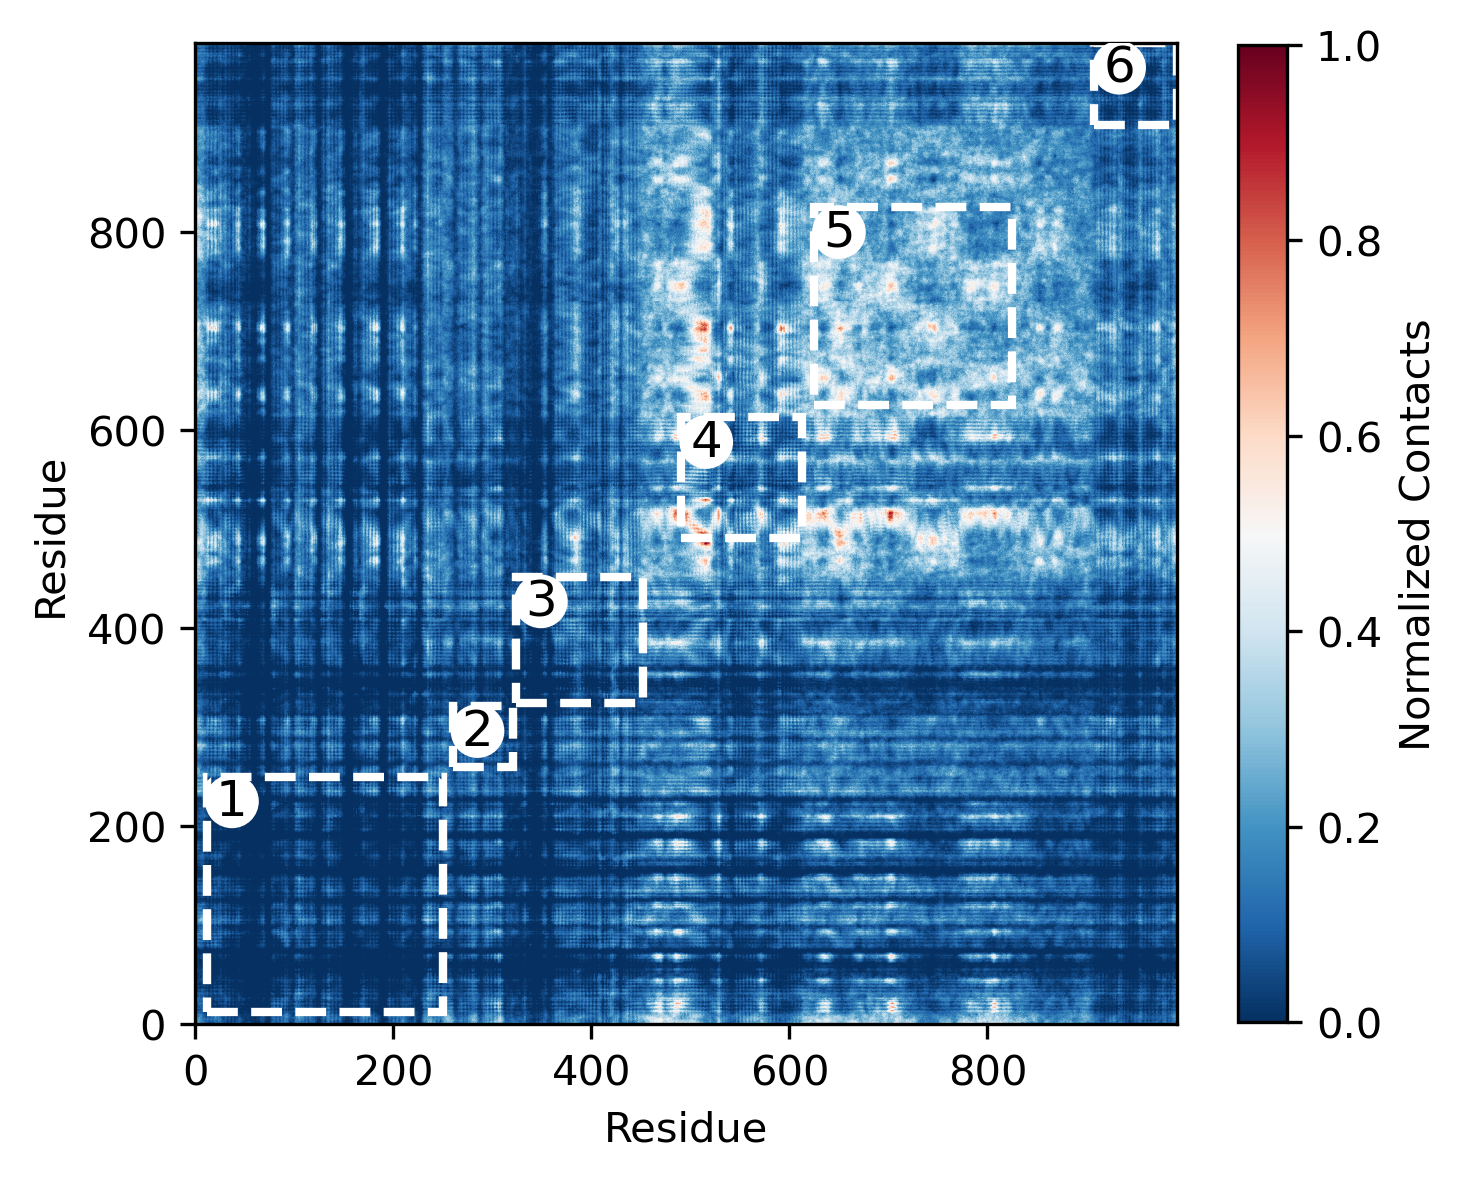

In [2]:
# FIGURE 4A - CONTACT MAP FOR HOMOTYPIC RECQ5 CONDENSATE
# Load molecular dynamics trajectory
u = mda.Universe('../Condensates/both_scaled/compressed_r5.pdb', '../Condensates/both_scaled/compressed_r5.dcd')
cutoff_distance = 15
c_len = 991
average_contacts = contact_map(u, cutoff_distance, c_len, c_len, -50, -1, 1)

# Save raw contact map data
os.makedirs('raw', exist_ok=True)
raw_data_filename = 'raw/RECQ5_Contact_Map.csv'
pd.DataFrame(average_contacts).to_csv(raw_data_filename, index=False, header=False)

# Define RECQ5 protein domains
domains = [
    {'name': 'Helicase ATP Binding', 'start': 12, 'end': 250, 'number': 1},
    {'name': 'Helicase C-Terminal', 'start': 260, 'end': 321, 'number': 2},
    {'name': 'RCQ Domain', 'start': 324, 'end': 452, 'number': 3},
    {'name': 'IRI Domain', 'start': 491, 'end': 613, 'number': 4},
    {'name': 'IDR Domain', 'start': 625, 'end': 825, 'number': 5},
    {'name': 'SRI Domain', 'start': 908, 'end': 991, 'number': 6}
]

# Create figure for contact map visualization
fig = plt.figure(figsize=(5, 5), dpi=300)

# Plot A: Average contacts matrix with domain annotations
ax_A = fig.add_subplot()  # Create subplot
cax_A = ax_A.imshow(average_contacts, cmap='RdBu_r', interpolation='nearest', origin='lower')

# Add domain annotations (rectangles and numbers)
for domain in domains:
    rect = plt.Rectangle((domain['start'], domain['start']),
                         domain['end'] - domain['start'],
                         domain['end'] - domain['start'],
                         linewidth=2, edgecolor='white', facecolor='none', linestyle='--')
    ax_A.add_patch(rect)
    
    # Add domain number inside a white circle
    circle_radius = 25
    circle_x = domain['start'] + circle_radius
    circle_y = domain['end'] - circle_radius
    circle = plt.Circle((circle_x, circle_y), radius=circle_radius, color='white', zorder=5)
    ax_A.add_patch(circle)
    
    ax_A.text(circle_x, circle_y, str(domain['number']), color='black',
              ha='center', va='center', fontsize=12, zorder=6)

# Set axis labels
ax_A.set_xlabel('Residue')
ax_A.set_ylabel('Residue')

# Add colorbar
cbar_A = fig.colorbar(cax_A, ax=ax_A, shrink=0.7, label='Normalized Contacts')

# Adjust plot limits
ax_A.set_xlim(0, 991)
ax_A.set_ylim(0, 991)

# Adjust layout and save figure
plt.tight_layout(w_pad=3)
plt.savefig('figures/RECQ5_Contact.pdf', format='pdf')


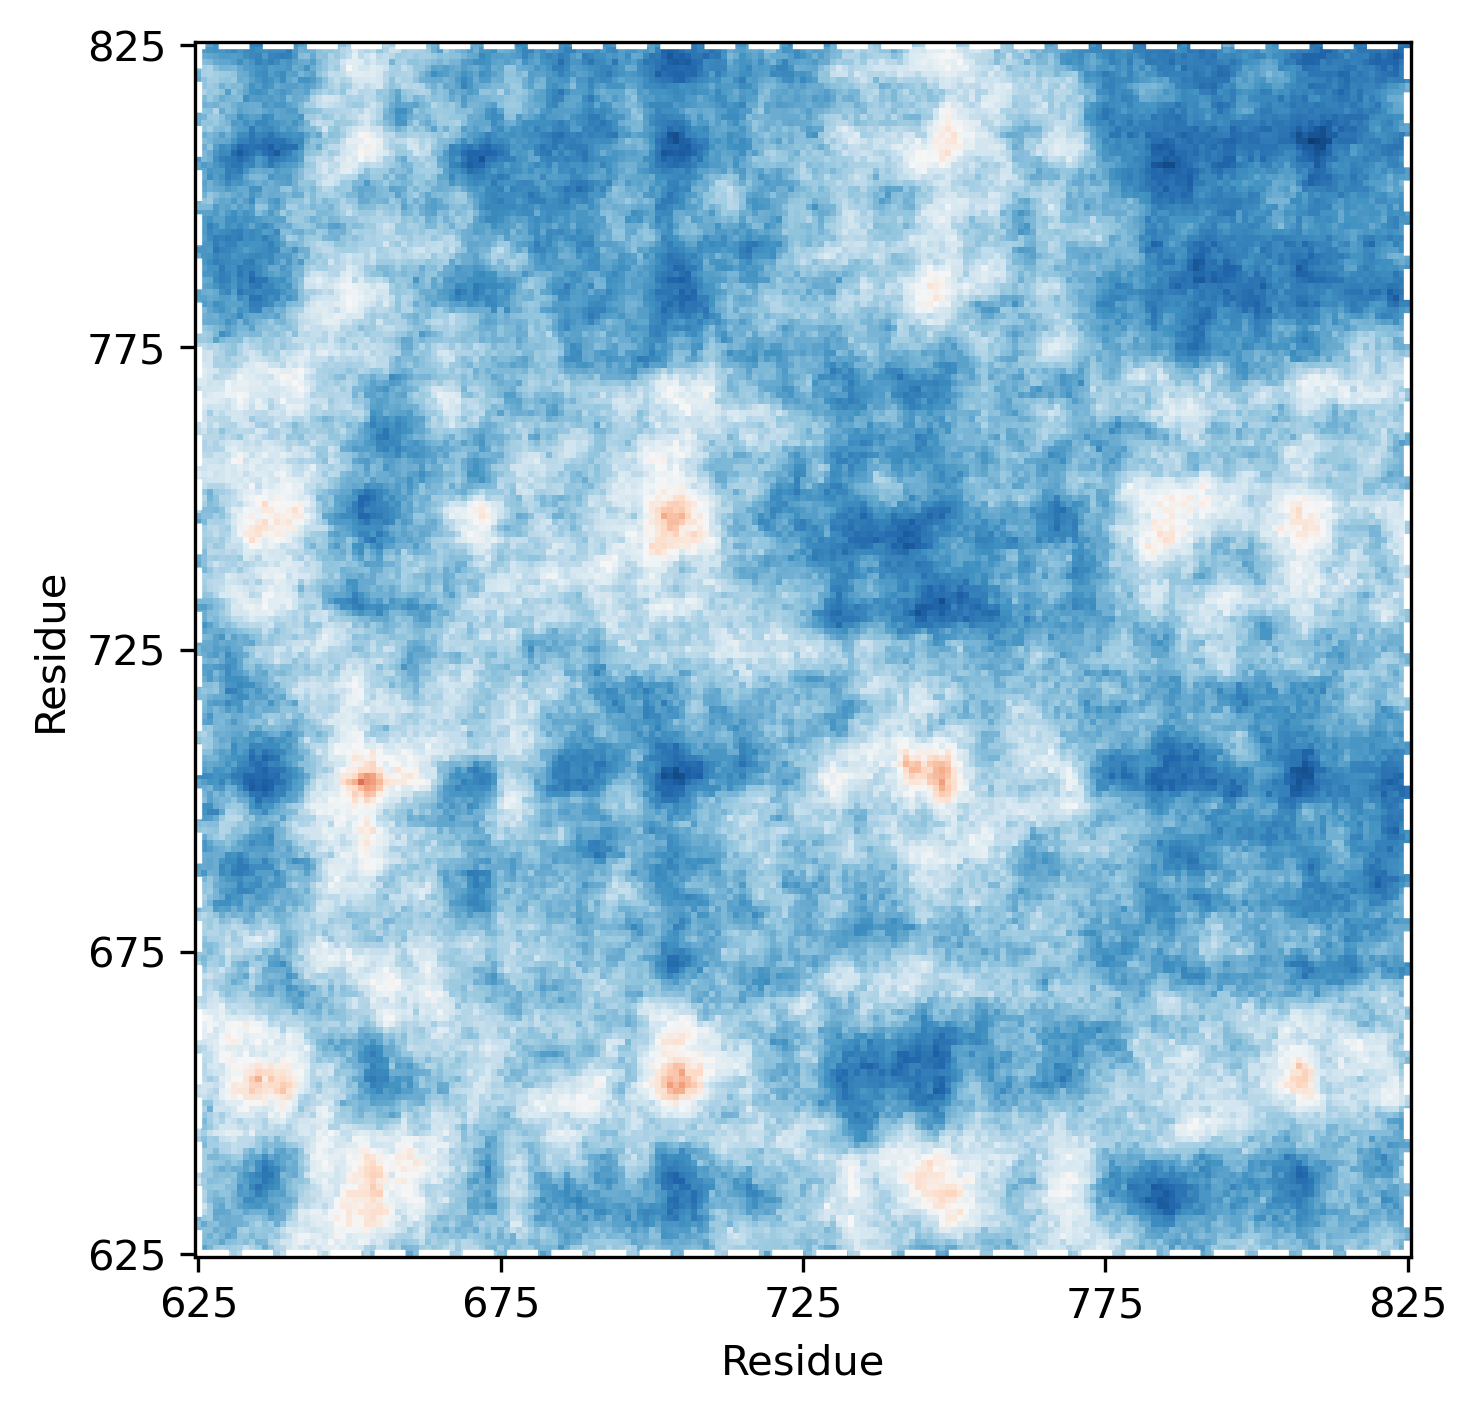

In [3]:
# FIGURE 4A - ZOOMED IN CONTACT MAP FOR HOMOTYPIC RECQ5 CONDENSATE
# Create figure for zoomed-in contact map
fig = plt.figure(figsize=(5, 5), dpi=300)
ax_B = fig.add_subplot()

# Define zoomed-in region (IDR Domain: Residues 625-825)
zoom_start = 625 - 1  # Adjust for zero-based index
zoom_end = 825 - 1
zoomed_contacts = average_contacts[zoom_start:zoom_end+1, zoom_start:zoom_end+1]

# Save raw zoomed contact data
os.makedirs('raw', exist_ok=True)
raw_zoomed_data_filename = 'raw/RECQ5_Contact_Map_Zoomed.csv'
pd.DataFrame(zoomed_contacts).to_csv(raw_zoomed_data_filename, index=False, header=False)

# Plot zoomed-in contact map
cax_B = ax_B.imshow(zoomed_contacts, cmap='RdBu_r', interpolation='nearest', origin='lower', vmin=0, vmax=1)
rect = plt.Rectangle((0, 0), zoom_end - zoom_start, zoom_end - zoom_start,
                     linewidth=2, edgecolor='white', facecolor='none', linestyle='--')
ax_B.add_patch(rect)

# Set axis labels
ax_B.set_xlabel('Residue')
ax_B.set_ylabel('Residue')

# Adjust tick labels to reflect actual residue numbers
tick_positions = np.linspace(0, zoom_end - zoom_start, num=5, dtype=int)
tick_labels = np.linspace(zoom_start + 1, zoom_end + 1, num=5, dtype=int)
ax_B.set_xticks(tick_positions)
ax_B.set_xticklabels(tick_labels)
ax_B.set_yticks(tick_positions)
ax_B.set_yticklabels(tick_labels)

# Remove colorbar if automatically added
if cax_B.colorbar:
    cax_B.colorbar.remove()

# Adjust layout and save figure
plt.tight_layout(w_pad=3)
plt.savefig('figures/RECQ5_Contact_zoomed.pdf', format='pdf')


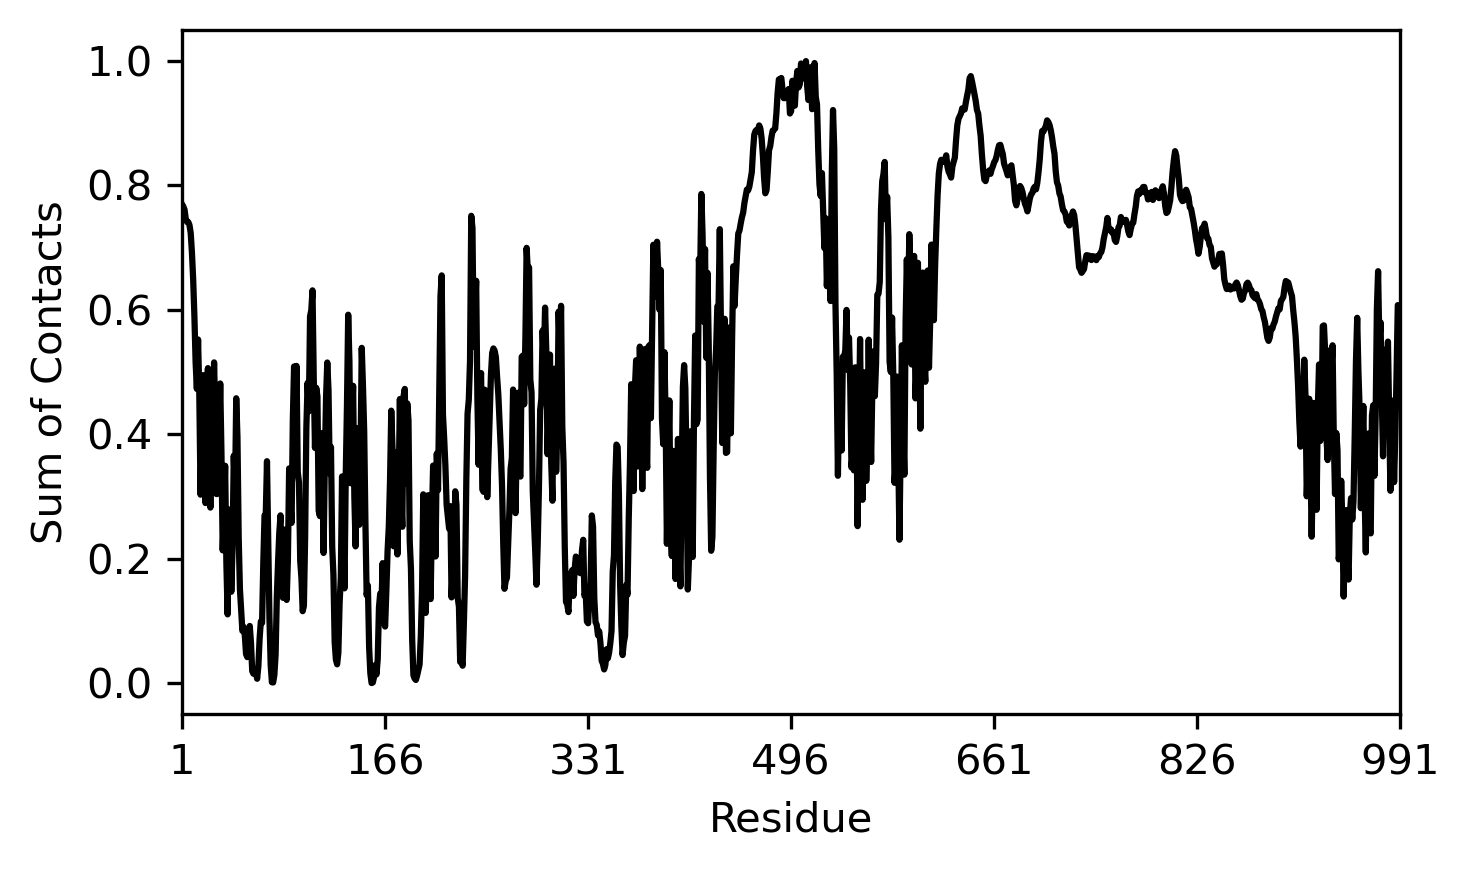

In [4]:
# FIGURE 4A - SUM OF CONTACT MAP ALONG AXIS FOR HOMOTYPIC RECQ5 CONDENSATE
# Compute the sum of contacts for each residue
sum_contacts = np.sum(average_contacts, axis=0)
summer = (sum_contacts - np.min(sum_contacts)) / (np.max(sum_contacts) - np.min(sum_contacts))
x_range = np.arange(1, len(summer) + 1)

# Save raw data
os.makedirs('raw', exist_ok=True)
raw_contacts_sum_filename = 'raw/R5_Contacts_Sum.csv'
pd.DataFrame({'Residue': x_range, 'Normalized Sum of Contacts': summer}).to_csv(raw_contacts_sum_filename, index=False)

# Create figure for plotting the sum of contacts
fig = plt.figure(figsize=(5, 3), dpi=300)
ax_C = fig.add_subplot()
ax_C.plot(x_range, summer, c='k')

# Set axis labels
ax_C.set_xlabel('Residue')
ax_C.set_ylabel('Sum of Contacts')
ax_C.set_xlim([1, 991])  # Ensure correct range
ax_C.set_xticks(np.linspace(1, 991, num=7, dtype=int))  # Adjust tick positions

# Adjust layout and save figure
plt.tight_layout()
plt.savefig('figures/R5_Contacts_sum.pdf', format='pdf', bbox_inches='tight')

# Display plot
plt.show()


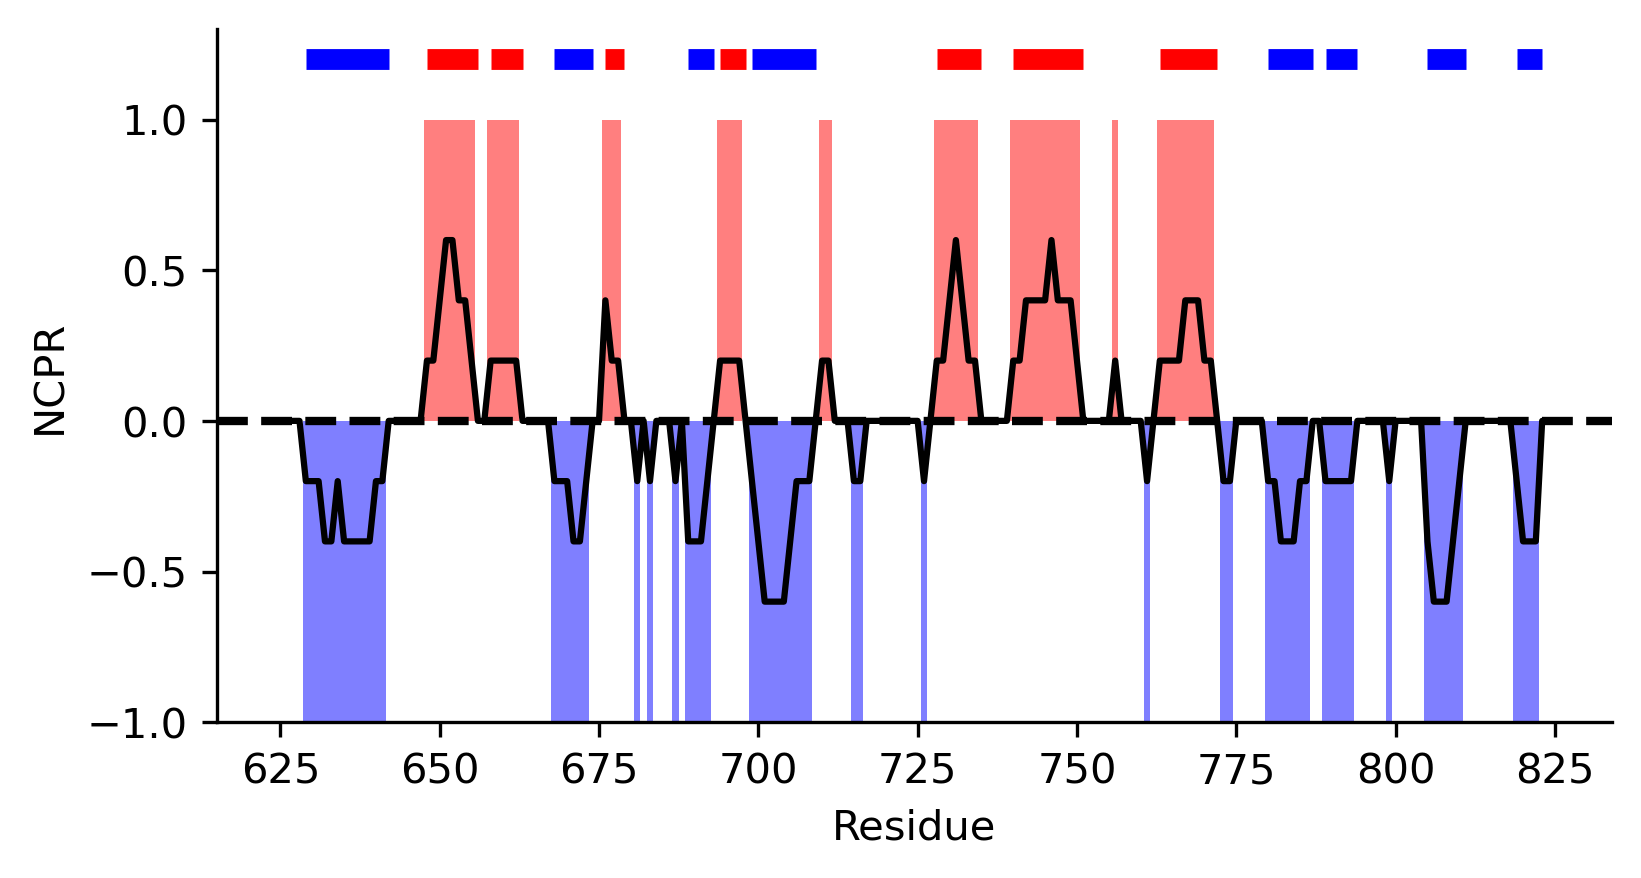

In [ ]:
# FIGURE 4A - NCPR OF RECQ5-IDR
# Load protein sequences from CSV file
csv_file = "../IDR_Mutations/proteins.csv"
df = pd.read_csv(csv_file)
sequence = df['Sequence'].iloc[0]
sequence_obj = SequenceParameters(sequence)
ncpr = sequence_obj.get_linear_NCPR(blobLen=5)
x_range = np.arange(625, 825)

# Save raw NCPR data
os.makedirs('raw', exist_ok=True)
raw_ncpr_filename = 'raw/NCPR_Data.csv'
pd.DataFrame({'Residue': x_range, 'NCPR': ncpr[1]}).to_csv(raw_ncpr_filename, index=False)

# Define charge-based colors for individual residues
colors = ['red' if val > 0 else 'blue' if val < 0 else 'gray' for val in ncpr[1]]
region_threshold = 3
regions = []
current_region = None

for i in range(len(ncpr[1]) - region_threshold + 1):
    subset = ncpr[1][i:i+region_threshold]
    
    if all(subset > 0):  # Positive charge region
        if current_region and current_region[1] == 'red':
            current_region[2] = i + region_threshold  # Extend current region
        else:
            if current_region:
                regions.append(current_region)  # Save previous region
            current_region = [i, 'red', i + region_threshold]  # Start new region
    
    elif all(subset < 0):  # Negative charge region
        if current_region and current_region[1] == 'blue':
            current_region[2] = i + region_threshold  # Extend current region
        else:
            if current_region:
                regions.append(current_region)  # Save previous region
            current_region = [i, 'blue', i + region_threshold]  # Start new region
    
    else:
        if current_region:
            regions.append(current_region)
            current_region = None

if current_region:
    regions.append(current_region)

# Create figure for NCPR plot
fig, ax = plt.subplots(figsize=(6, 3), dpi=300)
ax.plot(x_range, ncpr[1], color='black', linewidth=1.5, label="NCPR")
for i, color in enumerate(colors):
    bottom = -1 if color == 'blue' else 0
    if color != 'gray':
        ax.bar(x_range[i], 1, color=color, width=1, alpha=0.5, edgecolor='none', bottom=bottom)

# Add continuous charge regions as horizontal bars outside the main plot
for start, color, end in regions:
    ax.hlines(y=1.2, xmin=x_range[start], xmax=x_range[end], colors=color, linewidth=5)

# Formatting
ax.axhline(0, color='black', linestyle='--', linewidth=2)  # Neutral charge reference line
ax.set_xlabel("Residue")
ax.set_ylabel("NCPR")
ax.set_ylim(-1, 1.3)  # Expand y-limits to fit bars

# Remove top and right spines (graph box boundaries)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save figure
plt.savefig('figures/ncpr.pdf', format='pdf', bbox_inches='tight')

# Display plot
plt.show()


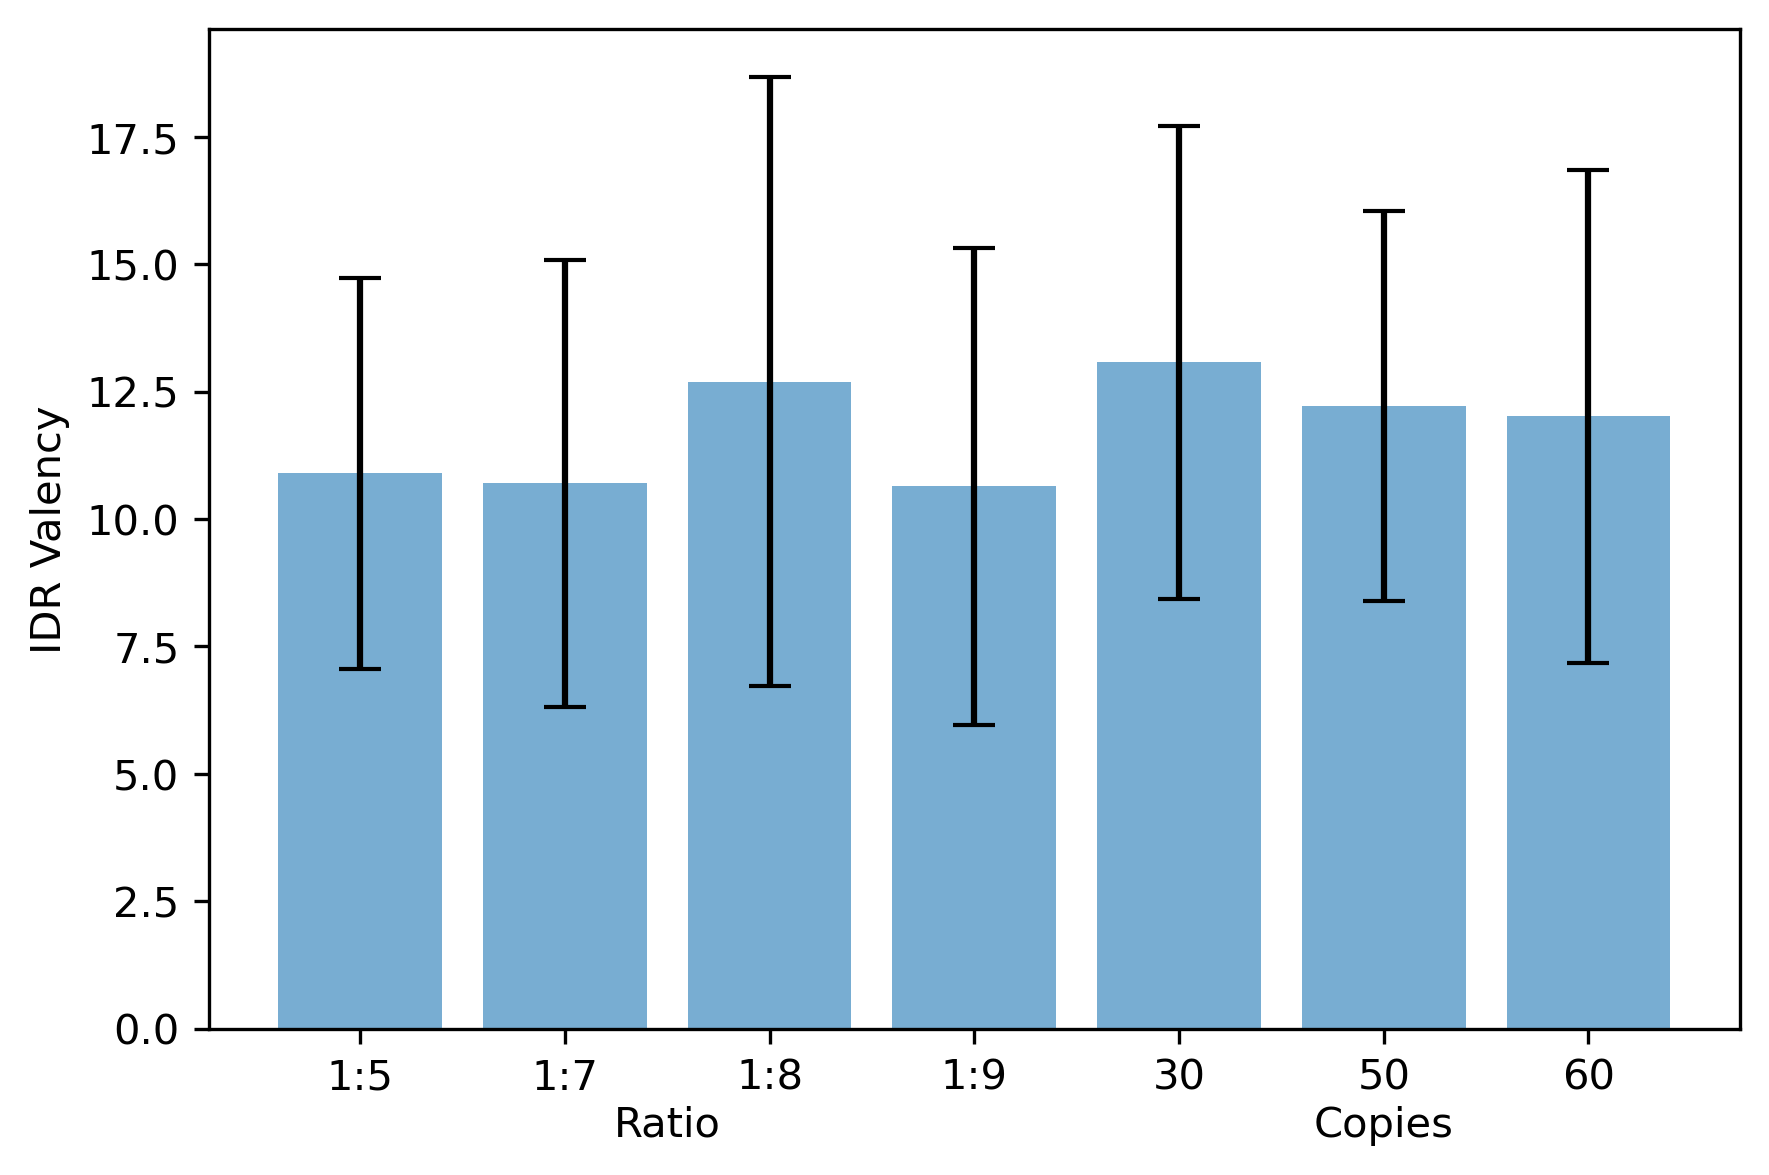

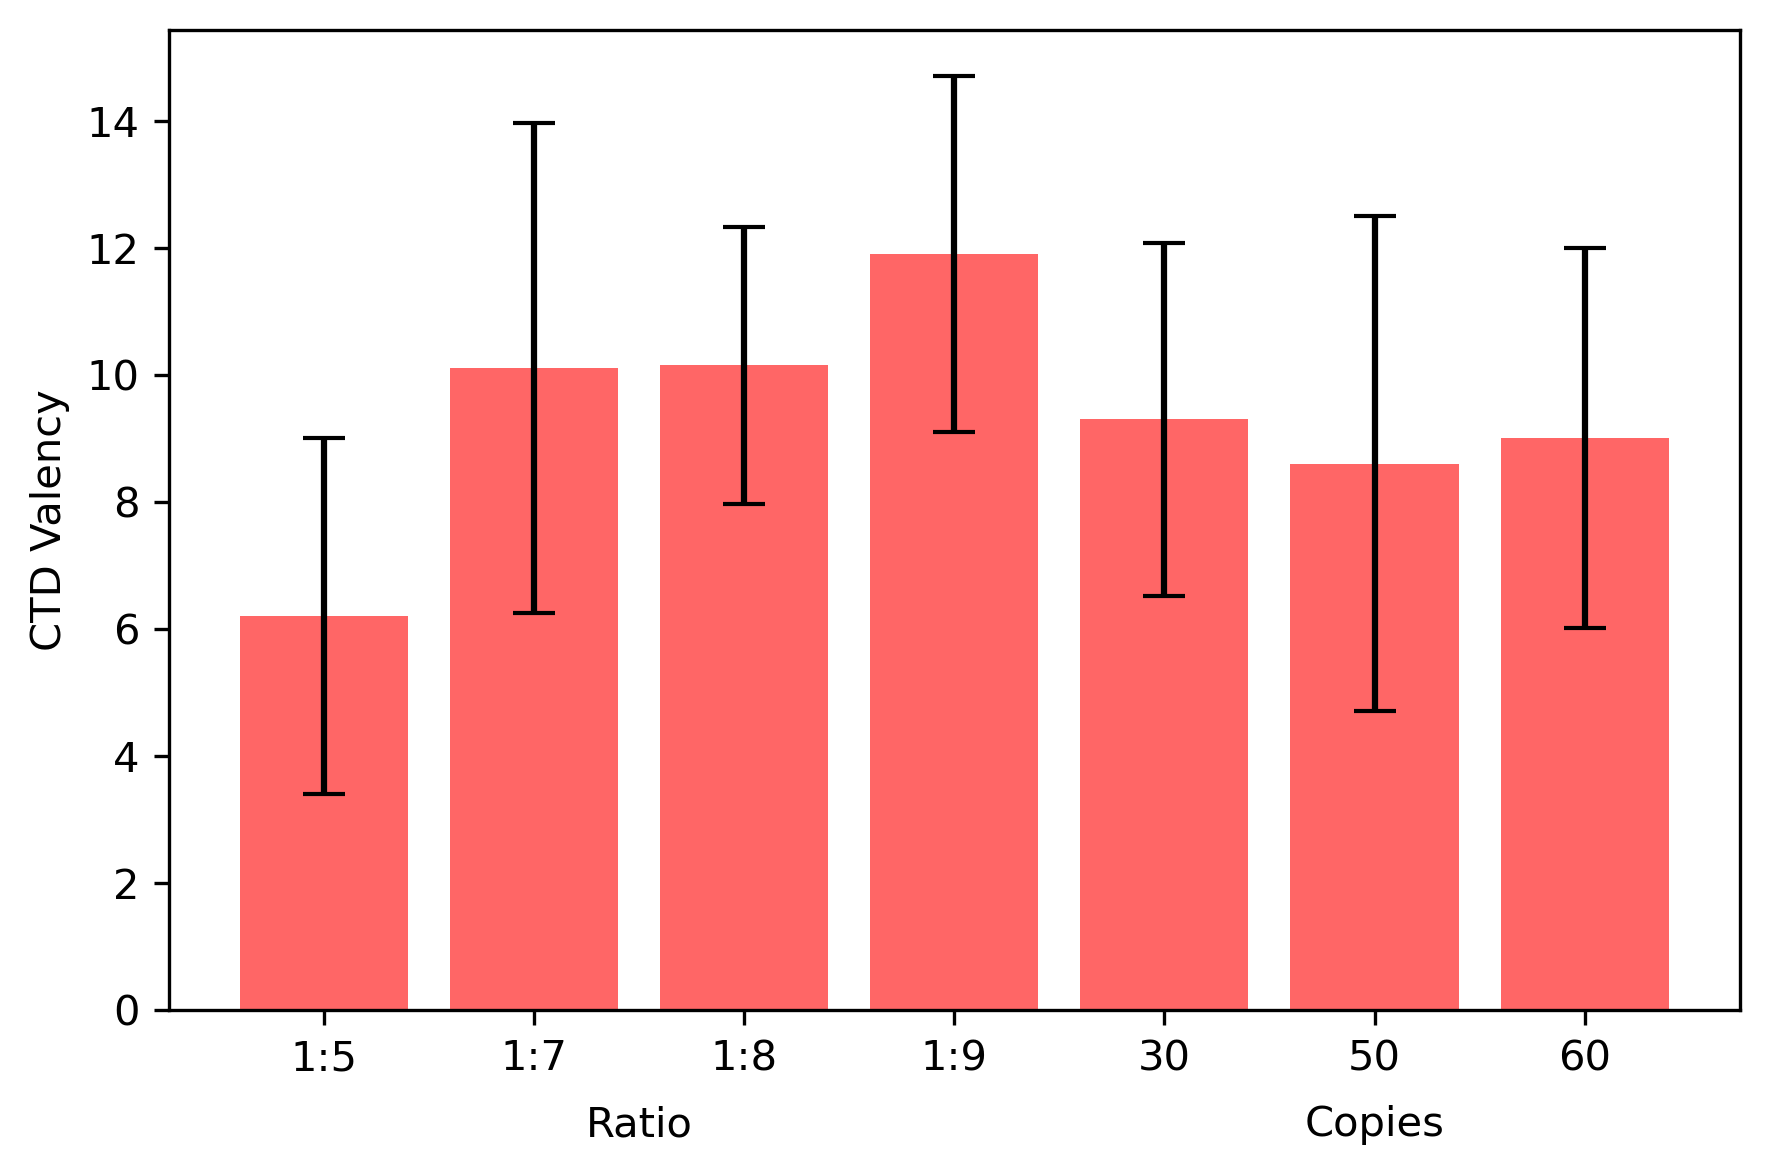

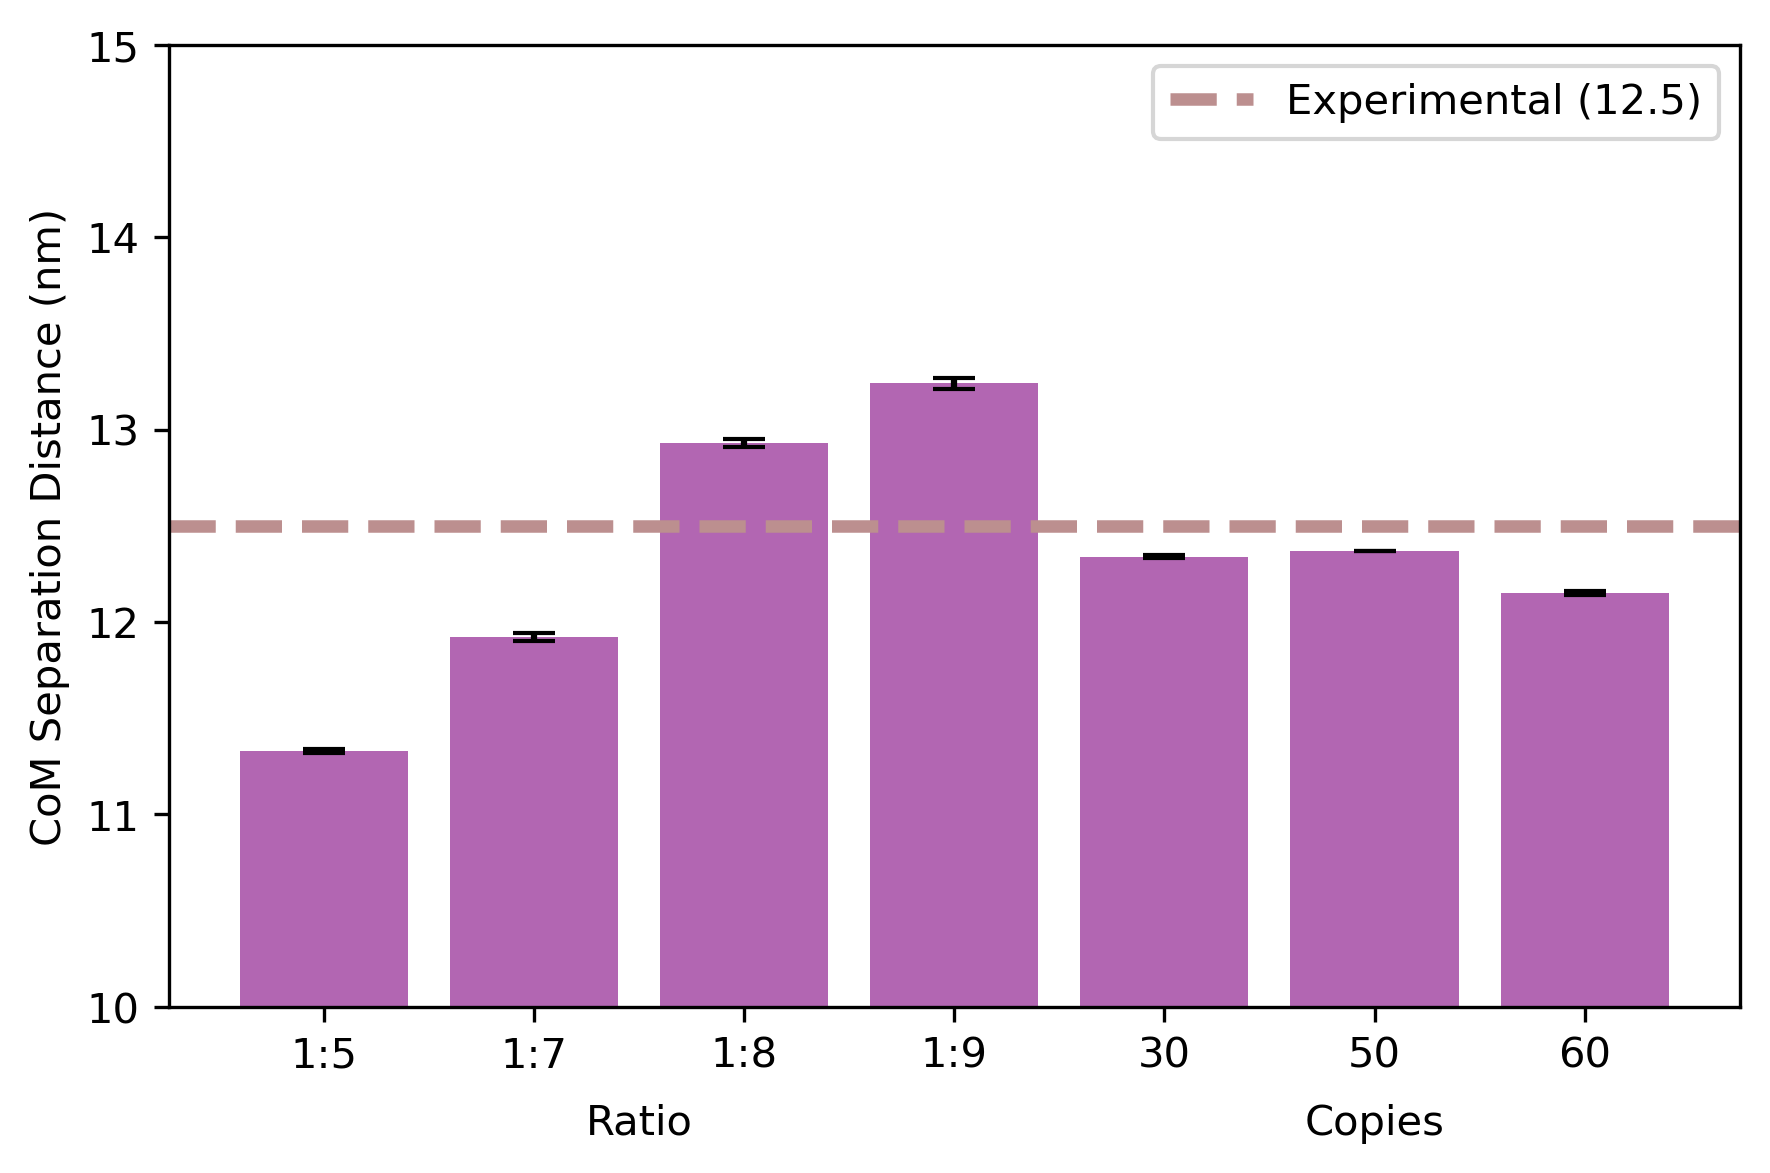

In [ ]:
# EXTENDED FIGURE 8A,C,D - INTERACTIONS BETWEEN DOMAINS

#names = ['1:3','1:5','1:10','50','60','70']
#idr = [4.75,6.39,8.10,7.73,7.74,7.51]
#idr_std = [2.57,2.77,3.19,3.26,3.19,3.33]
#sri = [4.27,6.68,9.1,6.99,6.91,6.99]
#sri_std = [2.46,2,3.12,2.34,2.53,2.6]

names = ['1:5', '1:7', '1:8', '1:9', '30', '50', '60']

# Define IDR valency data
idr = [10.9, 10.7, 12.7, 10.64, 13.08, 12.22, 12.02]
idr_std = [3.84, 4.39, 5.98, 4.69, 4.64, 3.83, 4.84]

# Define CTD valency data
sri = [6.2, 10.1, 10.15, 11.9, 9.3, 8.6, 9.0]
sri_std = [2.8, 3.86, 2.18, 2.80, 2.78, 3.90, 2.99]

# Define Center of Mass (CoM) separation distance data
com = [11.33, 11.92, 12.93, 13.24, 12.34, 12.37, 12.15]
com_std = [0.01, 0.02, 0.02, 0.03, 0.01, 0.001, 0.01]

# Define experimental reference values for CoM separation
r5 = 7.8
r5_std = 2.7
experimental_com = 12.5  # Experimental CoM separation distance

# Create directory for raw data if it doesn't exist
os.makedirs('raw', exist_ok=True)

# Save raw data for IDR Valency
raw_idr_filename = 'raw/IDR_Valency.csv'
pd.DataFrame({'Condition': names, 'IDR Valency': idr, 'Std Dev': idr_std}).to_csv(raw_idr_filename, index=False)

# Save raw data for CTD Valency
raw_sri_filename = 'raw/CTD_Valency.csv'
pd.DataFrame({'Condition': names, 'CTD Valency': sri, 'Std Dev': sri_std}).to_csv(raw_sri_filename, index=False)

# Save raw data for CoM Separation Distance
raw_com_filename = 'raw/CoM_Separation.csv'
pd.DataFrame({'Condition': names, 'CoM Separation (nm)': com, 'Std Dev': com_std}).to_csv(raw_com_filename, index=False)

# ----- Plot IDR Valency -----
fig, ax = plt.subplots(dpi=300, figsize=(6, 4))

# Plot IDR valency with error bars
ax.bar(np.arange(len(names)), idr, yerr=idr_std, capsize=5, label='IDR', alpha=0.6)

# Set axis labels and tick marks
ax.set_ylabel('IDR Valency')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)

# Add text labels for "Copies" and "Ratio" conditions
for i, label in enumerate(names):
    if label == '50':
        ax.text(i, -1.5, 'Copies', ha='center', va='top')
    if label == '1:7':
        ax.text(i + 0.5, -1.5, 'Ratio', ha='center', va='top')

plt.tight_layout()
plt.savefig('figures/idr_valency.pdf', format='pdf')

# ----- Plot CTD Valency -----
fig, ax = plt.subplots(dpi=300, figsize=(6, 4))
plt.grid(False)

# Plot CTD valency with error bars
ax.bar(np.arange(len(names)), sri, yerr=sri_std, capsize=5, color='red', alpha=0.6)

# Set axis labels and tick marks
ax.set_ylabel('CTD Valency')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)

# Add text labels for "Copies" and "Ratio" conditions
for i, label in enumerate(names):
    if label == '50':
        ax.text(i, -1.5, 'Copies', ha='center', va='top')
    if label == '1:7':
        ax.text(i + 0.5, -1.5, 'Ratio', ha='center', va='top')

plt.tight_layout()
plt.savefig('figures/sri_valency.pdf', format='pdf')

# ----- Plot CoM Separation Distance -----
fig, ax = plt.subplots(dpi=300, figsize=(6, 4))
plt.grid(False)

# Plot CoM separation distance with error bars
ax.bar(np.arange(len(names)), com, yerr=com_std, capsize=5, color='purple', alpha=0.6)

# Set axis labels and tick marks
ax.set_ylabel('CoM Separation Distance (nm)')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)

# Add experimental reference line
plt.axhline(experimental_com, c='rosybrown', linestyle='--', linewidth=3, label=f'Experimental ({experimental_com})')

# Add text labels for "Copies" and "Ratio" conditions
for i, label in enumerate(names):
    if label == '50':
        ax.text(i, -1.5 + 11, 'Copies', ha='center', va='top')
    if label == '1:7':
        ax.text(i + 0.5, -1.5 + 11, 'Ratio', ha='center', va='top')

# Set y-axis limits and add legend
plt.legend()
plt.ylim([10, 15])

plt.tight_layout()
plt.savefig('figures/com_sep.pdf', format='pdf')